## Лабораторная работа 3. Искусственные нейронные сети
Вам предлагается обучить трехслойную нейронную сеть прямого распространения с сигмоидальными функциями активации на
наборе данных MNIST — множестве изображений рукописных цифр и соответствующих метках 0-9.

Ваша задача заполнить код в следующих функциях:
- logistic — вычисляет логистическую функцию от аргумента,
- compute_hypothesis — вычисляет выходы сети для заданного набора данных,
- compute_cost — вычисляет функцию стоимости,
- compute_cost_grad — вычисляет градиент функции стоимости с помощью алгоритма обратного распространения ошибки.

logistic(0) = 0.5 (должно быть 0.5)
logistic(-10) = 4.5397868702434395e-05 (должно быть ~0)
logistic(10) = 0.9999546021312976 (должно быть ~1)

logistic_grad(0) = 0.25 (должно быть ~0.25)
logistic_grad(-10) = 4.5395807735951673e-05 (должно быть ~0)
logistic_grad(10) = 4.5395807735907655e-05 (должно быть ~0)


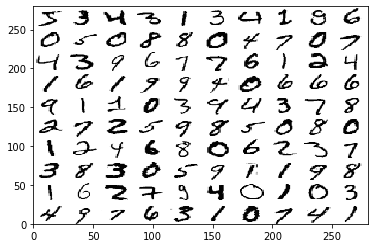

Запуск численного расчета градиента (может занять какое-то время)
0.0%
7.86%
15.71%
23.57%
31.42%
39.28%
47.13%
54.99%
62.84%
70.7%
78.55%
86.41%
94.27%
Градиент, посчитанный аналитически: 
[-0.00710141  0.00710141  0.00710141 ...  0.31389764  0.20706875
  0.2322866 ]
Градиент, посчитанный численно (должен примерно совпадать с предыдущим): 
[-0.00710141  0.00710141  0.00710141 ...  0.31389764  0.20706875
  0.2322866 ]

Относительное отклонение градиентов (должно быть < 1e-7): 
1.230388552073308e-09

Запуск оптимизации параметров сети (может занять какое-то время)
Минимизация функции стоимости прошла успешно.
Функция стоимости при оптимальных параметрах (должна быть < 0.5): 
0.3400030323601065
Доля верно распознаных цифр в обучающем наборе: 98.1 %
Доля верно распознаных цифр в тестовом наборе: 94.0 %


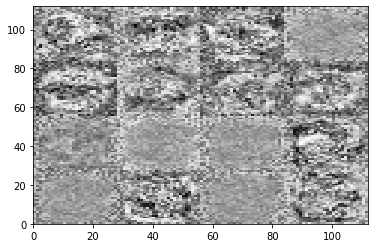

In [1]:
import numpy as np
import struct
from functools import reduce
from scipy.optimize import minimize
from matplotlib import pyplot as plt

# Ниже заданы "константы", с которыми можно "поиграть" - поварьировать их и посмотреть, что будет.
HIDDEN_LAYER_SIZE = 16  # Количество нейронов в скрытом слое.

# Всего у вас есть 60 000 изображений, поэтому сумма следующих двух констант не должна быть больше 60 000.
SAMPLES_TO_TRAIN = 5000  # Количество примеров в обучающей выборка, на ней будет производить подбор параметров модели.
SAMPLES_TO_TEST = 100  # Количество примеров в тестовой выборке, на ней будет оцениваться качество модели.


def one_hot_encode(y):
    # Функция кодирует вектор чисел с метками классов в матрицу, каждая строка которой является унитарным кодом
    # соответствующей метки.
    
    return np.array(np.arange(0, 10, 1) == y, dtype=np.int32)

def get_random_matrix(l_in, l_out):
    # Функция для генерации матрицы случайных параметров.

    return np.random.uniform(-0.5, 0.5, (l_out, l_in + 1))

def compute_cost_grad_approx(X, y, theta, lamb):
    # Фукнция для численного расчета градиента функции стоимости. Такой метод полезно использовать при проверке
    # правильности аналитического расчета.

    eps = 1e-5
    grad = np.zeros(theta.size)
    perturb = np.zeros(theta.size)
    for i in range(theta.shape[0]):
        if i % 1000 == 0:
            print(f'{round(i / theta.shape[0] * 100, 2)}%')
        perturb[i] = eps
        grad[i] = (compute_cost(X, y, theta + perturb, lamb) - compute_cost(X, y, theta - perturb, lamb)) / (2 * eps)
        perturb[i] = 0
    return grad


def logistic(z):
    # Функция принимает аргумент z - скаляр, вектор или матрицу в виде объекта numpy.array()
    # Должна возвращать скяляр, вектор или матрицу (в зависимости от размерности z)
    # результатов вычисления логистической функции от элементов z

    return 1 / (1 + np.exp(-z))


def logistic_grad(z):
    # Функция принимает аргумент z - скаляр, вектор или матрицу в виде объекта numpy.array()
    # Должна возвращать скаляр, вектор или матрицу (в зависимости от размерности z)
    # результатов вычисления производной логистической функции от элементов z

    return logistic(z) * (1 - logistic(z))


def compute_hypothesis(X, theta):
    # Функция принимает матрицу данных X без фиктивного признака и вектор параметров theta.
    # Вектор theta является "разворотом" матриц Theta1 и Theta2 в плоский вектор.
    # Функция должна возвращать матрицу выходов сети для каждого примера из обучающего набора,
    # а также матрицу входов нейронов скрытого слоя и матрицу выходов скрытого слоя (это понадобится для реализации
    # алгоритма обратного распространения ошибки).

    # Восстановление матриц Theta1 и Theta2 из ветора theta:
    # размерность Theta_l = (S_(l+1) x (S_l + 1))
    Theta1 = theta[:HIDDEN_LAYER_SIZE * (X.shape[1] + 1)].reshape(HIDDEN_LAYER_SIZE, X.shape[1] + 1)
    Theta2 = theta[HIDDEN_LAYER_SIZE * (X.shape[1] + 1):].reshape(10, HIDDEN_LAYER_SIZE + 1)

    X_fict = np.concatenate((np.reshape([1] * X.shape[0], (-1, 1)),
                             X), axis=1)
    
    Z2 = X_fict @ Theta1.T  # Будущая матрица входов скрытого слоя
    A2 = logistic(Z2)  # Будущая матрица выходов скрытого слоя
    
    A2_fict = np.concatenate((np.reshape([1] * A2.shape[0], (-1, 1)),
                              A2), axis=1)

    H = logistic(A2_fict @ Theta2.T)  # Будущая матрица выходов

    return H, Z2, A2


def compute_cost(X, y, theta, lamb):
    # Функция принимает матрицу данных X без фиктивного признака, вектор верных классов y,
    # вектор параметров theta и параметр регуляризации lamb.
    # Вектор theta является "разворотом" мартиц Theta1 и Theta2 в плоский вектор.
    # Должна вернуть значение функции стоимости в точке theta.

    m, n = X.shape  # m - количество примеров в выборке, n - количество признаков у каждого примера

    H = compute_hypothesis(X, theta)[0]

    # Восстановление матриц Theta1 и Theta2 из ветора theta:
    Theta1 = theta[:HIDDEN_LAYER_SIZE * (X.shape[1] + 1)].reshape(HIDDEN_LAYER_SIZE, X.shape[1] + 1)
    Theta2 = theta[HIDDEN_LAYER_SIZE * (X.shape[1] + 1):].reshape(10, HIDDEN_LAYER_SIZE + 1)

    y = np.array(list(map(lambda x: np.arange(0, 10, 1) == x, y)), dtype=np.int32)

    cost = -1 / m * np.sum(y * np.log(H) + (1 - y) * np.log(1 - H)) \
           + lamb / (2 * m) * (np.sum(Theta1 ** 2) + np.sum(Theta2 ** 2))

    return cost


def compute_cost_grad(X, y, theta, lamb):
    # Функция принимает матрицу данных X без фиктивного признака, вектор верных классов y,
    # вектор параметров theta и параметр регуляризации lamb.
    # Вектор theta является "разворотом" мартиц Theta1 и Theta2 в плоский вектор.
    # Функция должна реализовать алгоритм обратного распространения ошибки и вернуть матрицы градиентов весов связей.

    m, n = X.shape  # m - количество примеров в выборке, n - количество признаков у каждого примера

    H, Z2, A2 = compute_hypothesis(X, theta)
    
    X_fict = np.concatenate((np.reshape([1] * X.shape[0], (-1, 1)),
                             X), axis=1)
    A2_fict = np.concatenate((np.reshape([1] * A2.shape[0], (-1, 1)),
                              A2), axis=1)
    y = np.array(list(map(lambda x: np.arange(0, 10, 1) == x, y)), dtype=np.int32)

    # Восстановление матриц Theta1 и Theta2 из ветора theta:
    Theta1 = theta[:HIDDEN_LAYER_SIZE * (X.shape[1] + 1)].reshape(HIDDEN_LAYER_SIZE, X.shape[1] + 1)
    Theta2 = theta[HIDDEN_LAYER_SIZE * (X.shape[1] + 1):].reshape(10, HIDDEN_LAYER_SIZE + 1)

    Theta1_grad = None
    # Будущая матрица градиентов весов между входным и скрытым слоем, ее нужно заполнить
    Theta2_grad = None
    # Будущая матрица градиентов весов между скрытым и выходным слоем, ее нужно заполнить

    delta3 = H - y
    # (m x 10)

    delta2 = (delta3 @ Theta2[:, 1:]) * logistic_grad(Z2)
    # (m x HIDDEN_LAYER_SIZE)

    Delta_1 = delta2.T @ X_fict
    Delta_2 = delta3.T @ A2_fict

    Theta1_grad = 1/m * Delta_1 + lamb/m * Theta1
    Theta2_grad = 1/m * Delta_2 + lamb/m * Theta2

    return np.concatenate((Theta1_grad, Theta2_grad), axis=None)


def load_data_idx(file_path):
    with open(file_path, 'rb') as input_file:
        magic = input_file.read(4)
        dims = int(magic[3])
        sizes = [struct.unpack('>L', input_file.read(4))[0] for _ in range(dims)]
        size = reduce(lambda x, y: x * y, sizes)
        data = np.array(list(input_file.read(size)), dtype=float)
        data = data.reshape(sizes)
        return data

# Загрузка данных
images = load_data_idx('images.idx')
features = images.reshape((images.shape[0], images.shape[1] * images.shape[2])) / 128 - 1.0

labels = load_data_idx('labels.idx')

X = features[:SAMPLES_TO_TRAIN]
y = labels[:SAMPLES_TO_TRAIN]

X_test = features[SAMPLES_TO_TRAIN: SAMPLES_TO_TRAIN + SAMPLES_TO_TEST]
y_test = labels[SAMPLES_TO_TRAIN: SAMPLES_TO_TRAIN + SAMPLES_TO_TEST]

print(f'logistic(0) = {logistic(np.array(0))} (должно быть 0.5)\n'
      f'logistic(-10) = {logistic(np.array(-10))} (должно быть ~0)\n'
      f'logistic(10) = {logistic(np.array(10))} (должно быть ~1)')
print()
print(f'logistic_grad(0) = {logistic_grad(np.array(0))} (должно быть ~0.25)\n'
      f'logistic_grad(-10) = {logistic_grad(np.array(-10))} (должно быть ~0)\n'
      f'logistic_grad(10) = {logistic_grad(np.array(10))} (должно быть ~0)')

im_size = int(features.shape[1] ** 0.5)
hm = np.zeros((im_size * 10, im_size * 10))
for i in range(100):
    im_x = i % 10 * im_size
    im_y = i // 10 * im_size
    for j in range(features.shape[1]):
        px_x = im_x + j % im_size
        px_y = im_y + j // im_size
        hm[10 * im_size - 1 - px_x, px_y] = images[i, j % im_size, j // im_size]
plt.pcolor(hm, cmap='Greys')
plt.show()

lamb = 1  # можно поварьировать параметр регуляризации и посмотреть, что будет

init_Theta1 = np.random.uniform(-0.12, 0.12, (HIDDEN_LAYER_SIZE, X.shape[1] + 1))
init_Theta2 = np.random.uniform(-0.12, 0.12, (10, HIDDEN_LAYER_SIZE + 1))

init_theta = np.concatenate((init_Theta1, init_Theta2), axis=None)

back_prop_grad = compute_cost_grad(X[:10], y[:10], init_theta, 0)

print('Запуск численного расчета градиента (может занять какое-то время)')
num_grad = compute_cost_grad_approx(X[:10], y[:10], init_theta, 0)

print('Градиент, посчитанный аналитически: ')
print(back_prop_grad)

print('Градиент, посчитанный численно (должен примерно совпадать с предыдущим): ')
print(num_grad)

print()
print('Относительное отклонение градиентов (должно быть < 1e-7): ')
print((np.linalg.norm(back_prop_grad - num_grad) / np.linalg.norm(back_prop_grad + num_grad)))

print()
print('Запуск оптимизации параметров сети (может занять какое-то время)')
opt_theta_obj = minimize(lambda th: compute_cost(X, y, th, lamb), init_theta,
                         method='CG',
                         jac=lambda th: compute_cost_grad(X, y, th, lamb),
                         options={'gtol': 1e-3, 'maxiter': 3000, 'disp': False})

print('Минимизация функции стоимости ' + ('прошла успешно.' if opt_theta_obj.success else 'не удалась.'))

opt_theta = opt_theta_obj.x
print('Функция стоимости при оптимальных параметрах (должна быть < 0.5): ')
print(compute_cost(X, y, opt_theta, lamb))

hypos_train = compute_hypothesis(X, opt_theta)[0]

true_preds_train_num = 0
for k in range(hypos_train.shape[0]):
    max_el = np.max(hypos_train[k, :])
    true_preds_train_num += list(np.array(hypos_train[k, :] == max_el, dtype=np.int32)) == list(one_hot_encode(y[k]))
print('Доля верно распознаных цифр в обучающем наборе:', true_preds_train_num / hypos_train.shape[0] * 100, '%')

hypos_test = compute_hypothesis(X_test, opt_theta)[0]

true_preds_test_num = 0
for k in range(hypos_test.shape[0]):
    max_el = np.max(hypos_test[k, :])
    true_preds_test_num += list(np.array(hypos_test[k, :] == max_el, dtype=np.int32)) == list(one_hot_encode(y_test[k]))
print('Доля верно распознаных цифр в тестовом наборе:', true_preds_test_num / hypos_test.shape[0] * 100, '%')


if HIDDEN_LAYER_SIZE ** 0.5 % 1.0 == 0:
    Theta1 = opt_theta[:HIDDEN_LAYER_SIZE * (X.shape[1] + 1)].reshape(HIDDEN_LAYER_SIZE, X.shape[1] + 1)
    Theta1 = Theta1[:, 1:]
    Theta1 = (Theta1 - Theta1.mean(axis=0)) / (Theta1.std(axis=0))
    Theta1 = Theta1.reshape(HIDDEN_LAYER_SIZE, 28, 28)
    im_size = int(features.shape[1] ** 0.5)
    size_imgs = int(HIDDEN_LAYER_SIZE ** 0.5)
    hm = np.zeros((im_size * size_imgs, im_size * size_imgs))
    for i in range(HIDDEN_LAYER_SIZE):
        im_x = i % size_imgs * im_size
        im_y = i // size_imgs * im_size
        for j in range(features.shape[1]):
            px_x = im_x + j % im_size
            px_y = im_y + j // im_size
            hm[size_imgs * im_size - 1 - px_x, px_y] = Theta1[i, j % im_size, j // im_size]
    plt.pcolor(hm, cmap='Greys')
    plt.show()

Для борьбы с переобучением:

- lamb = 0.5 => 1  
- HIDDEN_LAYER_SIZE = 25 => 16  
- SAMPLES_TO_TRAIN = 1000 => 5000  